# Predicting iPhone Prices using Linear Regression and Converting Prices to a Target Currency:

1. The notebook aims to build a linear regression model to predict iPhone prices based on the iPhone version and then convert the predicted prices from USD to a target currency specified by the user.

2. The model uses the historical data of iPhone prices to train and predict the prices of new versions.

3. Additionally, it incorporates currency conversion using an exchange rate API to provide predicted prices in the user-specified currency.

4. The goal is to help users estimate the prices of iPhones in their desired currency based on the version of the iPhone they are interested in.

# Cell 1: Import the required libraries and suppress warnings

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import requests

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Cell 2: Load the dataset and display the first few rows

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/9394113857/Data-Sets/c45efacb19b01448b5a649a648a5469a37786f6b/iphone_price.csv')
df.head()

,version,price
0,1,499
1,2,599
2,3,599
3,4,649
4,5,649


# Cell 3: Data Preprocessing

In [ ]:
# Handle missing values
df.dropna(inplace=True)

# Split the data into features (x) and target (y)
x = df['version'].values.reshape(-1, 1)
y = df['price'].values.reshape(-1, 1)

# Scale features using StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
x_scaled

array([[-1.59325501],
       [-1.30357228],
       [-1.01388955],
       [-0.72420682],
       [-0.43452409],
       [-0.14484136],
       [ 0.14484136],
       [ 0.43452409],
       [ 0.72420682],
       [ 1.01388955],
       [ 1.30357228],
       [ 1.59325501]])

# Cell 4: Exploratory Data Analysis (EDA)

<Axes: >

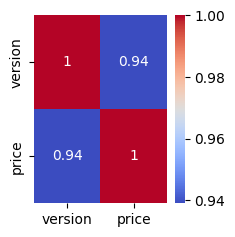

In [ ]:
import seaborn as sns

# Pairplot to visualize the relationship between variables
sns.pairplot(df, x_vars=['version'], y_vars=['price'], kind='scatter')

# Heatmap to visualize correlations
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

# Cell 5: Train-test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# Cell 6: Model Selection and Hyperparameter Tuning

In [ ]:
models = [
    ('Linear Regression', LinearRegression(), {}),
    ('Ridge Regression', Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
    ('Lasso Regression', Lasso(), {'alpha': [0.1, 1.0, 10.0]}),
    ('Decision Tree', DecisionTreeRegressor(), {'max_depth': [None, 10, 20]}),
    ('Random Forest', RandomForestRegressor(), {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]})
]

best_model = None
best_model_name = ""
best_score = float('-inf')

for name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    score = grid_search.best_score_
    if score > best_score:
        best_score = score
        best_model = grid_search.best_estimator_
        best_model_name = name

    print(f"{name}: Best Parameters - {grid_search.best_params_}, Best Score - {score}")

print()
print("=================")
print(f"Best Model: {best_model_name}, Best Score: {best_score}")

Linear Regression: Best Parameters - {}, Best Score - -26464.51226874625
Ridge Regression: Best Parameters - {'alpha': 1.0}, Best Score - -25175.284912510386
Lasso Regression: Best Parameters - {'alpha': 0.1}, Best Score - -26467.641235422703
Decision Tree: Best Parameters - {'max_depth': None}, Best Score - -25370.0
Random Forest: Best Parameters - {'max_depth': 10, 'n_estimators': 100}, Best Score - -26371.074000000004

Best Model: Ridge Regression, Best Score: -25175.284912510386


# Cell 7: Fit the best model

In [ ]:
best_model.fit(x_train, y_train)

Ridge()

# Cell 8: Evaluate the model

In [ ]:
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"R-squared: {r2}")

Train RMSE: 96.6469681870139
Test RMSE: 90.34464688739051
R-squared: 0.9160464034390108


# Cell 9: Save the best model using pickle

In [ ]:
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Cell 10: Load the saved model

In [ ]:
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Cell 11: Make a single prediction for any version

In [ ]:
def predict_iphone_price(iphone_version, exchange_rate):
    # Use the loaded linear regression model to predict the corresponding price based on the input version
    prediction_value = loaded_model.predict([[iphone_version]])

    # Convert the predicted price from dollars to rupees using the provided exchange rate
    dollar = prediction_value[0][0]
    rupees = dollar * exchange_rate

    # Print the predicted price in dollars and rupees
    # Note: The `prediction_value` variable is assumed to be a 2D array from the `predict` method,
    # so we access the predicted value using indexing [0][0].
    # The "\033[1m" escape code is used to make the text bold, and "\033[0m" is used to reset the formatting to normal.
    print("\033[1mThe Dollar Amount is:\033[0m", dollar, "Dollars")
    print("\033[1mThe Amount in Rupees is:\033[0m", rupees, "Rupees")

# Cell 12: Get the exchange rate using exchangerate-api.com

In [ ]:
def get_exchange_rate(api_key, base_currency, target_currency):
    url = f"https://v6.exchangerate-api.com/v6/{api_key}/pair/{base_currency}/{target_currency}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("conversion_rate", None)
    else:
        print("Failed to fetch exchange rates.")
        return None

# Cell 13: Main function to get exchange rate and predict price in rupees

In [ ]:
def main():
    api_key = "24deb0ef1b10d0e1838a1e1b"
    base_currency = "USD"
    target_currency = "INR"

    exchange_rate = get_exchange_rate(api_key, base_currency, target_currency)
    if exchange_rate is not None:
        print(f"1 {base_currency} = {exchange_rate} {target_currency}")
        try:
            iphone_version = float(input("Please Enter iPhone_version: "))
        except ValueError:
            print("Invalid input. Please enter a valid numeric value.")
            return

        predict_iphone_price(iphone_version, exchange_rate)

if __name__ == "__main__":
    main()

1 USD = 82.9472 INR
Please Enter iPhone_version: 13
The Dollar Amount is: 3696.631652271058 Dollars
The Amount in Rupees is: 306625.2449872579 Rupees


# What is the best model in this code?

1.	**In the provided code,** the best model is determined through **hyperparameter tuning and cross-validation.** The code tests multiple regression models and selects the one with the best performance based on the **negative mean squared error (MSE) score.** The model with the lowest negative MSE is considered the best model for this specific dataset and evaluation metric.**

2.	**After running the hyperparameter tuning loop, the code prints the name of the best model and its corresponding best score (negative MSE).** In this case, the best model is either Linear Regression, Ridge Regression, Lasso Regression, Decision Tree, or Random Forest, **depending on which one had the lowest negative MSE during the cross-validation process.**

3.	**The actual model name and its performance may vary depending on the dataset** and the **random state used during the train-test split.** To find out the specific best model and its hyperparameters for the dataset you are using, you can check the printed output after running the code.

4.  The line that prints the best model's name and score is:

5.  **print(f"Best Model: {best_model_name}, Best Score: {best_score}")**

6.  **Best Model:** Ridge Regression, **Best Score:** -25175.284912510386




In [ ]:
import requests
import pickle

def get_exchange_rate(api_key, base_currency, target_currency):
    url = f"https://v6.exchangerate-api.com/v6/{api_key}/pair/{base_currency}/{target_currency}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("conversion_rate", None)
    else:
        print("Failed to fetch exchange rates.")
        return None

def predict_iphone_price(iphone_version, exchange_rate):
    # Load the saved linear regression model from the file 'best_model.pkl'
    with open('best_model.pkl', 'rb') as file:
        loaded_model = pickle.load(file)

    # Use the loaded linear regression model to predict the corresponding price based on the input version
    prediction_value = loaded_model.predict([[iphone_version]])

    # Convert the predicted price from dollars to the target currency using the provided exchange rate
    price_in_dollars = prediction_value[0][0]
    price_in_target_currency = price_in_dollars * exchange_rate

    # Print the predicted price in dollars and the target currency
    print("\033[1mThe Dollar Amount is:\033[0m", price_in_dollars, "Dollars")
    print("\033[1mThe Amount in Target Currency is:\033[0m", price_in_target_currency)

def main():
    api_key = '24deb0ef1b10d0e1838a1e1b'
    base_currency = "USD"
    target_currency = input("Please enter your target currency (e.g., INR, EUR, GBP, etc.): ")

    exchange_rate = get_exchange_rate(api_key, base_currency, target_currency)
    if exchange_rate is not None:
        print(f"1 {base_currency} = {exchange_rate} {target_currency}")
        try:
            iphone_version = float(input("\nPlease Enter iPhone_version: "))
        except ValueError:
            print("Invalid input. Please enter a valid numeric value.")
            return

        predict_iphone_price(iphone_version, exchange_rate)

if __name__ == "__main__":
    main()

Please enter your target currency (e.g., INR, EUR, GBP, etc.): inr
1 USD = 82.9472 inr

Please Enter iPhone_version: 13
The Dollar Amount is: 3696.631652271058 Dollars
The Amount in Target Currency is: 306625.2449872579
